# Naver movie review sentiment analysis by using RNN

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)
import warnings
warnings.filterwarnings('ignore')

Set korean font

In [4]:
!brew update -qq
!brew install fonts-nanum* -qq

/bin/bash: brew: command not found
/bin/bash: brew: command not found


font-manager rebuild

In [5]:
import matplotlib.font_manager as fm
fm._rebuild()

In [6]:
plt.rc('font', family = 'NanumGothic')

In [7]:
!pip install Konlpy

     |████████████████████████████████| 19.4MB 50.4MB/s 
     |████████████████████████████████| 450kB 51.0MB/s 
     |████████████████████████████████| 92kB 13.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [8]:
import konlpy
konlpy.__version__

'0.5.2'

In [9]:
train_df = pd.read_csv('naver_review_train.csv', sep = '\t')
test_df = pd.read_csv('naver_review_test.csv', sep = '\t')

## Preprocessing

### 한글 형태소 분석

In [10]:
from konlpy.tag import Okt
import tqdm.notebook as tn

In [11]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']
okt = Okt()

In [12]:
X_train = []
for sentence in tn.tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem = True)
    temp_X = [i for i in morphs if not i in stopwords]
    X_train.append(temp_X)

In [13]:
X_test = []
for sentence in tn.tqdm(test_df.document):
    morphs = okt.morphs(sentence, stem = True)
    temp_X = [i for i in morphs if not i in stopwords]
    X_test.append(temp_X)

In [14]:
X_train[:5]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다']]

### Encoding with keras

In [15]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
max_words = 30000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
X_train[:5]

[[48, 450, 15, 256, 655],
 [929, 453, 40, 598, 1, 210, 1445, 23, 957, 671, 18],
 [382, 2440, 25011, 2311, 5667, 2, 218, 8],
 [6488, 102, 8114, 214, 54, 3, 25, 3599],
 [1019,
  19412,
  28,
  9141,
  23,
  829,
  1,
  2575,
  20,
  1104,
  236,
  14239,
  19413,
  1072,
  250,
  236]]

In [18]:
print('Length of the longest reviews :', max(len(i) for i in X_train))
print('Average length of reviews :', sum(map(len, X_train)) / len(X_train))

Length of the longest reviews : 69
Average length of reviews : 10.660699220116468


In [19]:
max_len = 40
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [20]:
y_train = train_df.label.values
y_test = test_df.label.values

## Processing

In [21]:
model = Sequential([ 
    Embedding(max_words, 120),
    LSTM(128),
    Dense(1, activation = 'sigmoid')                    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         3600000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               127488    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,727,617
Trainable params: 3,727,617
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
import os

if not os.path.exists('Models') :
    os.mkdir('Models')
    
model_file = 'Models/naver-lstm-best-model.h5'
mc = ModelCheckpoint(model_file, save_best_only = True, verbose = 1)

In [24]:
history = model.fit(X_train, y_train, validation_split = 0.2, batch_size = 60, epochs = 4, callbacks = [mc])

Epoch 1/4
1944/1944 [==============================] - 78s 36ms/step - loss: 0.3868 - accuracy: 0.8238 - val_loss: 0.3509 - val_accuracy: 0.8472

Epoch 00001: val_loss improved from inf to 0.35088, saving model to Models/naver-lstm-best-model.h5
Epoch 2/4
1944/1944 [==============================] - 70s 36ms/step - loss: 0.2890 - accuracy: 0.8769 - val_loss: 0.3414 - val_accuracy: 0.8521

Epoch 00002: val_loss improved from 0.35088 to 0.34139, saving model to Models/naver-lstm-best-model.h5
Epoch 3/4
1944/1944 [==============================] - 69s 36ms/step - loss: 0.2326 - accuracy: 0.9047 - val_loss: 0.3768 - val_accuracy: 0.8506

Epoch 00003: val_loss did not improve from 0.34139
Epoch 4/4
1944/1944 [==============================] - 68s 35ms/step - loss: 0.1860 - accuracy: 0.9249 - val_loss: 0.4117 - val_accuracy: 0.8463

Epoch 00004: val_loss did not improve from 0.34139


In [25]:
best_model = load_model(model_file)
best_model.evaluate(X_test, y_test)

1532/1532 [==============================] - 6s 3ms/step - loss: 0.3481 - accuracy: 0.8483


[0.34806230664253235, 0.8483314514160156]

## Visualization

In [26]:
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(1, len(y_acc)+1)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


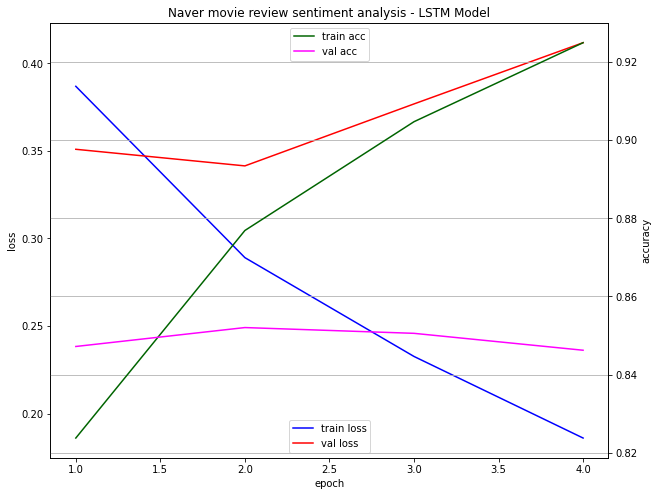

In [27]:
fig, ax0 = plt.subplots(figsize = (10,8))
ax1 = ax0.twinx()

ax0.plot(x_len, y_loss, c = 'blue', label = 'train loss')
ax0.plot(x_len, y_vloss, c = 'red', label = 'val loss')
ax0.set_ylabel('loss')

ax1.plot(x_len, y_acc, c = 'darkgreen', label = 'train acc')
ax1.plot(x_len, y_vacc, c = 'magenta', label = 'val acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')

ax0.legend(loc = 'lower center'); ax1.legend(loc = 'upper center')
plt.title('Naver movie review sentiment analysis - LSTM Model')
plt.grid()
plt.show()

# GRU model

In [28]:
from tensorflow.keras.layers import GRU

model2 = Sequential([ 
    Embedding(max_words, 120),
    GRU(128),
    Dense(1, activation = 'sigmoid')                    
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 120)         3600000   
_________________________________________________________________
gru (GRU)                    (None, 128)               96000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,696,129
Trainable params: 3,696,129
Non-trainable params: 0
_________________________________________________________________


In [29]:
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [30]:
model2_file = 'Models/naver-lstm-best-model2.h5'
mc2 = ModelCheckpoint(model2_file, save_best_only = True, verbose = 1)

In [31]:
history2 = model2.fit(X_train, y_train, validation_split = 0.2, batch_size = 60, epochs = 4, callbacks = [mc2])

Epoch 1/4
1944/1944 [==============================] - 69s 35ms/step - loss: 0.3816 - accuracy: 0.8256 - val_loss: 0.3427 - val_accuracy: 0.8506

Epoch 00001: val_loss improved from inf to 0.34272, saving model to Models/naver-lstm-best-model2.h5
Epoch 2/4
1944/1944 [==============================] - 67s 35ms/step - loss: 0.2830 - accuracy: 0.8808 - val_loss: 0.3368 - val_accuracy: 0.8540

Epoch 00002: val_loss improved from 0.34272 to 0.33683, saving model to Models/naver-lstm-best-model2.h5
Epoch 3/4
1944/1944 [==============================] - 67s 34ms/step - loss: 0.2238 - accuracy: 0.9091 - val_loss: 0.3728 - val_accuracy: 0.8494

Epoch 00003: val_loss did not improve from 0.33683
Epoch 4/4
1944/1944 [==============================] - 67s 34ms/step - loss: 0.1735 - accuracy: 0.9312 - val_loss: 0.4399 - val_accuracy: 0.8431

Epoch 00004: val_loss did not improve from 0.33683


In [32]:
best_model2 = load_model(model2_file)
best_model2.evaluate(X_test, y_test)

1532/1532 [==============================] - 5s 3ms/step - loss: 0.3431 - accuracy: 0.8488


[0.3430517911911011, 0.8488008975982666]